# Ross-Macdonald Malaria Modeling

Authors: Sean L. Wu and Sophie Libkind

In [1]:
using AlgebraicDynamics
using Catlab.WiringDiagrams, Catlab.Graphics

using LabelledArrays

using DelayDiffEq, DifferentialEquations
using Plots

The Ross-Macdonald (RM) model is the canonical model of malaria transmission, first expressed by
Sir Ronald Ross in 1911. The simplest form of the model is given by a system of 2 nonlinear ordinary
differential equations describing $Z$, parasite prevalence in the mosquito vector population, and $X$,
parasite prevalence in the vertebrate host population:
$$ \dot X = mazbZ(1 - X) - rX, \quad \dot Z = acX (e^{-gn} - Z) - gZ  \quad (1)$$

The RM model is of supreme importance to modeling of malaria and other mosquito transmitted diseases
because it is the simplest model that retains the fundamental processes involved in transmission: recovery
of infected hosts, death of infected mosquitoes, and parasite transmission between discordant pairs of
vectors and hosts. In this sense it represents the irreducible complexity to modeling mosquito borne
diseases, such that any simpler model would be insufficient.

The model assumes that mosquitoes take bloodmeals (bites) on vertebrate hosts with rate $a$.
Therefore, the per-capita rate at which susceptible mosquitoes become infected is $acX$, where $c$
is the transmission efficiency from infectious humans to susceptible mosquitoes (probability of
parasites successfully invading the mosquito given a bite occurs) and $X$ is the probability the
 bite lands on an infectious human. $1-Z$ is the proportion of mosquitoes who are susceptible but
given an incubation period of $n$ days during which mosquitoes suffer per-capita mortality at rate
$g$, only a proportion $e^{-gn}$ survive incubation to become infectious. Therefore the classic
RM model will have statics that are consistent with the incorporation of an incubation period of
fixed duration, but dynamics will not, as the delay is not incorporated into the equations.

Susceptible humans acquire infection at a rate $mabZ$, where $m = M/H$, the ratio of mosquitoes to
humans, $a$ is as before, and $b$ is the transmission efficiency from infectious mosquitoes to
susceptible humans. Therefore $mabZ$ gives the per-capita rate at which susceptible humans recieve
parasites from the mosquito population. Infectious humans recover at a rate $r$ (the rate at which the
immune system clears parasites). Because $m$ is considered a constant parameter, the model ignores
seasonal fluctuations in mosquito (or host) population sizes. However, because the timescale of host
dynamcis is typically slow in relation to mosquito dynamics, the approximation is often suitable
over a transmission season.

The model's threshold criterion between the trivial equilibrium where both $Z,X$ are equal to zero
(no disease) and the endemic equilibrium can be expressed by the basic reproductive number, giving
the expected number of secondary infections arising from the introduction of a single infectious human,
$$R_0 = \frac{ma^2bce^{-gn}}{rg}.$$ The endemic equilibrium is therefore:
$$\bar{X}= \frac{R_{0}-1}{R_{0} + \frac{ac}{g}}, \quad \bar{Z} = \frac{ac\bar{X}}{g + ac\bar{X}} e^{-gn}.$$

From these equations, the nonlinear relationships that characterize observed malaria transmission can be
understood. We implement them as follows:

## Diagram of Systems
First we must construct a diagram of systems which describes the interaction between the mosquito and
host populations. The arrows between the two subsystems represents the bidirectional infection during bloodmeals.

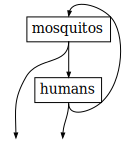

In [2]:
rm = WiringDiagram([], [:mosquitos, :humans])
mosq_box   = add_box!(rm, Box(:mosquitos, [:x], [:z]))
human_box  = add_box!(rm, Box(:humans, [:z], [:x]))
output_box = output_id(rm)

add_wires!(rm, Pair[
    (mosq_box, 1)  => (human_box, 1),
    (human_box, 1) => (mosq_box, 1),
    (mosq_box, 1)  => (output_box, 1),
    (human_box, 1) => (output_box, 2)]
)


to_graphviz(rm)

## ODE Model
Next we implement the concrete mosquito and host dynamics given in Equation (1), and apply them to the diagram
of systems. This composition is the complete Ross-Macdonald model which we can solve and plot.

In [3]:
dZdt = function(u,x,p,t)
    Z = u[1]
    X = x[1]
    [p.a*p.c*X*(exp(-p.g*p.n) - Z) - p.g*Z]
end

dXdt = function(u,x,p,t)
    X = u[1]
    Z = x[1]
    [p.m*p.a*p.b*Z*(1 - X) - p.r*X]
end

#3 (generic function with 1 method)

In [4]:
mosquito_model = ContinuousMachine{Float64}(1, 1, 1, dZdt, (u,p,t) -> u)
human_model    = ContinuousMachine{Float64}(1, 1, 1, dXdt, (u,p,t) ->  u)

malaria_model = oapply(rm,
    Dict(:humans => human_model, :mosquitos => mosquito_model)
)

In [5]:
params = LVector(a = 0.3, b = 0.55, c = 0.15,
    g = 0.1, n = 10, r = 1.0/200, m = 0.5)

u0 = [0.1, 0.3]
tspan = (0.0, 365.0*2)

prob = ODEProblem(malaria_model, u0, tspan, params)
sol = solve(prob, Tsit5());

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/VS2ST/src/performance_warnings.jl:32


┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


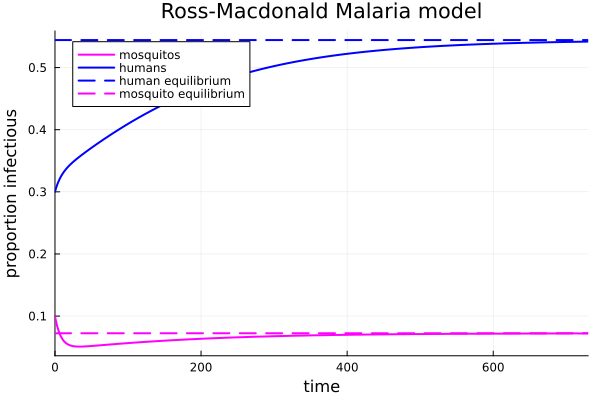

In [6]:
plot(sol, malaria_model,
    lw=2, title = "Ross-Macdonald Malaria model",
    xlabel = "time", ylabel = "proportion infectious",
    color = ["magenta" "blue"]
)

# Plot the equilibrium behavior as well
a, b, c, g, n, r, m = params
R0 = (m*a^2*b*c*exp(-g*n))/(r*g)
X̄ = (R0 - 1)/(R0 + (a*c)/g)
Z̄ = (a*c*X̄)/(g + a*c*X̄)*exp(-g*n)

N = length(sol)
plot!(sol.t, fill(X̄, N), label = "human equilibrium", ls = :dash, lw = 2, color = "blue")
plot!(sol.t, fill(Z̄, N), label = "mosquito equilibrium", ls = :dash, lw = 2, color = "magenta")

## ODE Model using instantaneous machines
One way to decouple systems or isolate coupling points between different parts of a dynamical system
is to use instantaneous machines, which allow processing of information to occur without (optionally) storing
state themselves.

In this case we seperate the bloodmeal, where pathogen transmission occurs between the two
species, into a seperate machine. This way, the dynamics of the human and mosquito machines
do not need the other's state value, all the information has already been computed in
the bloodmeal machine. For such a simple system, this arrangement may be superfluous, but in
complex systems it can be beneficial to have seperate components which compute terms which
are dependent on state variables "external" to a particular machine.

In [7]:
rmb = WiringDiagram([], [:mosquitos, :humans, :bloodmeal])
mosquito_box = add_box!(rmb, Box(:mosquitos, [:κ], [:Z]))
human_box = add_box!(rmb, Box(:humans, [:EIR], [:X]))
bloodmeal_box = add_box!(rmb, Box(:bloodmeal, [:X, :Z], [:κ, :EIR]))
output_box = output_id(rmb)

add_wires!(rmb, Pair[
    (bloodmeal_box, 1)  => (mosquito_box, 1),
    (bloodmeal_box, 2) => (human_box, 1),
    (human_box, 1)  => (bloodmeal_box, 1),
    (mosquito_box, 1) => (bloodmeal_box, 2),
    (mosquito_box, 1)  => (output_box, 1),
    (human_box, 1) => (output_box, 2)]
)

The wiring diagram is below. The bloodmeal machine computes the EIR (entomological inoculation rate)
which is proportional to the force of infection upon susceptible humans, and the net infectiousness
of humans to mosquitoes, commonly denoted $\kappa$. The EIR is $maZ$ where $Z$ is the mosquito
state variable, and $\kappa$ is $cX$ where $X$ is the human state variable.

These two terms are sent from the bloodmeal machine to the mosquito and human machines
via their input ports. Then the dynamical system filling the mosquito machine is
$\dot{Z} = a\kappa (e^{-gn} - Z) - gZ$ and $\dot{X} = bEIR(1-X) - rX$ is the dynamical system
filling the human machine.

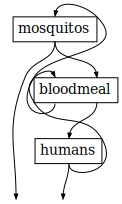

In [8]:
to_graphviz(rmb)

In [9]:
bloodmeal = function(u,x,p,t)
    X = x[1]
    Z = x[2]
    [p.c*X, p.m*p.a*Z]
end

dZdt = function(u,x,p,t)
    Z = u[1]
    κ = x[1]
    [p.a*κ*(exp(-p.g*p.n) - Z) - p.g*Z]
end

dXdt = function(u,x,p,t)
    X = u[1]
    EIR = x[1]
    [p.b*EIR*(1 - X) - p.r*X]
end

bloodmeal_model = InstantaneousContinuousMachine{Float64}(2, 0, 2, (u,x,p,t)->u, bloodmeal, [1=>1,2=>2])
mosquito_model = ContinuousMachine{Float64}(1, 1, 1, dZdt, (u,p,t) -> u)
human_model    = ContinuousMachine{Float64}(1, 1, 1, dXdt, (u,p,t) ->  u)

instantaneous_mosquito_model = InstantaneousContinuousMachine{Float64}(mosquito_model)
instantaneous_human_model = InstantaneousContinuousMachine{Float64}(human_model)

malaria_model = oapply(rmb,
    Dict(:mosquitos => instantaneous_mosquito_model, :humans => instantaneous_human_model, :bloodmeal => bloodmeal_model)
)

We use the same parameter values as previously given to solve the composed system, and plot
the analytic equilibrium. Results are the same as for the previous system.

In [10]:
prob = ODEProblem(malaria_model, u0, tspan, params)
sol = solve(prob, Tsit5());

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/VS2ST/src/performance_warnings.jl:32


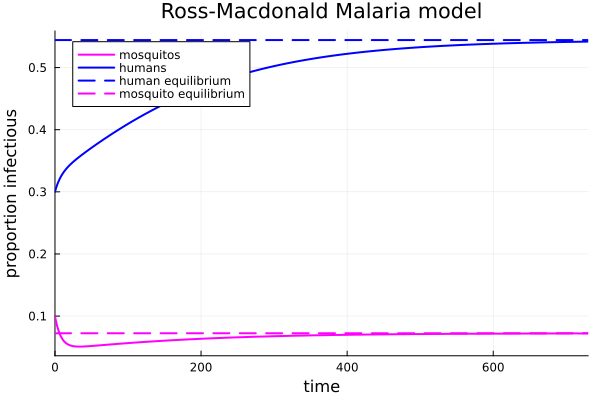

In [11]:
plot(sol, label = ["mosquitos" "humans"],
    lw=2, title = "Ross-Macdonald Malaria model",
    xlabel = "time", ylabel = "proportion infectious",
    color = ["magenta" "blue"]
)
N = length(sol)
plot!(sol.t, fill(X̄, N), label = "human equilibrium", ls = :dash, lw = 2, color = "blue")
plot!(sol.t, fill(Z̄, N), label = "mosquito equilibrium", ls = :dash, lw = 2, color = "magenta")

## Delay Model
The previous models did not capture the incubation period for the disease in the
mosquito population. To do so we can replace the models with delay differential equations
and apply them to the same diagram of systems representing the bloodmeal.

In [12]:
dzdt_delay = function(u,x,h,p,t)
    Y, Z = u
    Y_delay, Z_delay = h(p, t - p.n)
    X, X_delay = x[1]

    [p.a*p.c*X*(1 - Y - Z) -
        p.a*p.c*X_delay*(1 - Y_delay - Z_delay)*exp(-p.g*p.n) -
        p.g*Y,
    p.a*p.c*X_delay*(1 - Y_delay - Z_delay)*exp(-p.g*p.n) -
        p.g*Z]
end

dxdt_delay = function(u,x,h,p,t)
    X, = u
    Z, _ = x[1]
    [p.m*p.a*p.b*Z*(1 - X) - p.r*X]
end

#23 (generic function with 1 method)

In [13]:
mosquito_delay_model = DelayMachine{Float64, 2}(
    1, 2, 1, dzdt_delay, (u,h,p,t) -> [[u[2], h(p,t - p.n)[2]]])

human_delay_model = DelayMachine{Float64, 2}(
    1, 1, 1, dxdt_delay, (u,h,p,t) -> [[u[1], h(p, t - p.n)[1]]])

malaria_delay_model = oapply(rm,
    Dict(:humans => human_delay_model, :mosquitos => mosquito_delay_model)
)

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/VS2ST/src/performance_warnings.jl:32


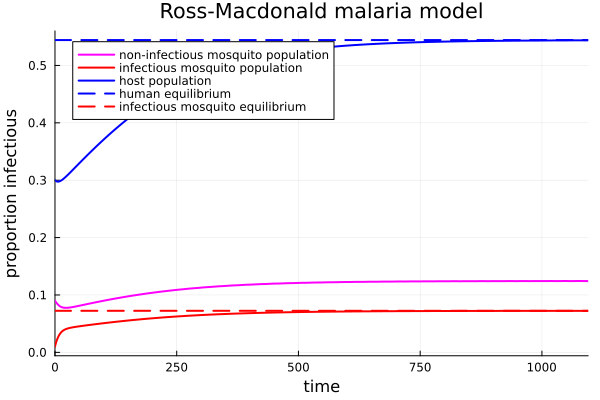

In [14]:
params = LVector(a = 0.3, b = 0.55, c = 0.15,
    g = 0.1, n = 10, r = 1.0/200, m = 0.5)

u0_delay = [0.09, .01, 0.3]
tspan = (0.0, 365.0*3)
hist(p,t) = u0_delay;

prob = DDEProblem(malaria_delay_model, u0_delay, [], hist, tspan, params)
alg = MethodOfSteps(Tsit5())
sol = solve(prob, alg)

plot(sol, label=["non-infectious mosquito population" "infectious mosquito population" "host population"],
    lw=2, title = "Ross-Macdonald malaria model",
    xlabel = "time", ylabel = "proportion infectious",
    color = ["magenta" "red" "blue"]
)
N = length(sol)
plot!(sol.t, fill(X̄, N), label = "human equilibrium", ls = :dash, lw = 2, color = "blue")
plot!(sol.t, fill(Z̄, N), label = "infectious mosquito equilibrium", ls = :dash, lw = 2, color = "red")

While the equilibrium points of the two models are identical, they exhibit different dynamical behavior
before settling down to equilibrium. Because models are often used to examine how the system may respond
to intervention, incorporating additional biological realism can produce more plausible results regarding
the expected time for interventions to affect the system. In any case, such simple models are best used as
tools to explain basic concepts in malaria epidemiology rather than descriptions of real systems, which are
likely far from equilibrium and affected by weather, climate, policy, and other external forces.